In [1]:
import os
from pathlib import Path
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 12-1 (Indexing - Multi-Vector (Summary))"

In [4]:
DATA_PATH = Path('../../data')

# Indexing

![](images/indexing-01.png)

# Part 12-1: Multi-Vector (Summary)

![](images/12-01-multi-vector-summary.png)

## Configure components

In [5]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9654a743ed', 'id': 'chatcmpl-BKOvlH8Wxfv1ntq53Ighlt3tut3Gq', 'finish_reason': 'stop', 'logprobs': None}, id='run-9290585e-ba89-41bf-9e53-e06534c1ee37-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

2

In [10]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [11]:
print(docs[1].page_content[:1000])



      Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection involves attention to details and careful execution. The community knows the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et al. 2021).

Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#


In [12]:
[len(doc.page_content) for doc in docs]

[43130, 29018]

## Summarize documents

In [13]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain

In [14]:
summarization_prompt_template = "Summarize the following document:\n\n{doc}"
print(summarization_prompt_template)

Summarize the following document:

{doc}


In [15]:
@chain
def summarize_document(doc):
    summarization_prompt = summarization_prompt_template.format(
        doc=doc.page_content
    )
    response = llm.invoke([
        HumanMessage(content=summarization_prompt)
    ])
    return response.content

In [16]:
summaries = summarize_document.batch(docs, {"max_concurrency": len(docs)})

for summary in summaries:
    rprint(Markdown(summary))
    rprint('='*100)

The document "LLM Powered Autonomous Agents" by Lilian Weng delves into the development and functioning of         
autonomous agents utilizing large language models (LLMs) as their core control system. These agents can perform    
complex tasks through effective planning, memory management, and tool utilization. Key highlights include:         

 1 Agent System Components:                                                                                        
    • Planning: Involves breaking down tasks into subgoals through techniques like Chain of Thought (CoT) and Tree 
      of Thoughts. Agents can refine their strategies through self-reflection.                                     
    • Memory: Agents utilize both short-term and long-term memory, with mechanisms for in-context learning and     
      external vector storage for retrieving data.                                                                 
    • Tool Use: Agents interact with external APIs to enhance information access and execution capabilities.       
 2 Task Decomposition & Self-Reflection:                                                                           
    • Various strategies improve task handling and allow agents to learn from past mistakes. Techniques like ReAct,
      Reflexion, and Chain of Hindsight focus on enhancing reasoning and improving outcomes based on feedback.     
 3 Memory Types:                                                                                                   
    • The document categorizes memory as sensory, short-term, and long-term, drawing parallels to human memory     
      systems, explaining how LLMs process and utilize information.                                                
 4 Tool Utilization:                                                                                               
    • Examples of frameworks like MRKL, TALM, and Toolformer illustrate the integration of external tools for      
      executing tasks. A conversation around HuggingGPT shows how LLMs can be effectively managed to execute       
      complex tasks.                                                                                               
 5 Case Studies:                                                                                                   
    • The document showcases practical applications like ChemCrow, a science-based agent that uses expert tools,   
      and Generative Agents, which simulate human behavior in a virtual environment, demonstrating the versatility 
      of LLM-powered agents.                                                                                       
 6 Challenges:                                                                                                     
    • Common limitations are acknowledged, including the finite context length, issues in long-term planning, and  
      the reliability of natural language interfaces. These aspects hinder the robustness and efficacy of          
      LLM-powered agents in real-world applications.                                                               
 7 Conclusion:                                                                                                     
    • The document emphasizes the promise and potential of LLM-powered autonomous agents, recognizing both their   
      capabilities and the obstacles that still require addressing.                                                

Overall, the text serves as a comprehensive overview of the principles and practical implementations of LLM-based  
autonomous agents, exploring current research and developing frameworks in this emerging field.

====================================================================================================

The document "Thinking about High-Quality Human Data" by Lilian Weng discusses the importance of high-quality human
data in the training of machine learning models, particularly deep learning models relying on human annotations. It
emphasizes that effective data collection involves detailed task design, proper selection and training of          
annotators, and careful data collection and integration. The author cites historical examples and research to      
illustrate the concept of "the wisdom of the crowd" and the potential biases in data annotation from non-experts.  

The document provides insights into the complexities of achieving data quality, highlighting methodologies for     
assessing and improving annotation reliability, such as majority voting, inter-rater agreement measures, and       
probabilistic graph modeling. It contrasts two paradigms in crowdsourcing annotations: the prescriptive approach,  
which advocates for a single interpretation of data, and the descriptive approach, which encourages diverse        
perspectives.                                                                                                      

Additionally, the text details innovative ways to analyze raters' disagreements and the implications for data      
quality. It introduces frameworks such as Jury Learning and disagreement deconvolution that improve predictive     
models by accounting for annotators’ characteristics and differing opinions.                                       

Finally, it examines techniques used in identifying mislabeled data during model training, including influence     
functions and prediction changes during training, which help developers filter out erroneous data points.          

In summary, Weng underlines that while achieving high-quality human data is crucial, it is also a complex process  
that requires careful attention to various factors, methodologies, and the insights drawn from human behavior in   
annotation tasks.

====================================================================================================

## Store documents

In [17]:
from operator import attrgetter
import uuid

from langchain_core.documents import Document
from langchain_core.stores import InMemoryByteStore
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [18]:
vectorstore = InMemoryVectorStore(embeddings)
store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

summary_docs = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]})
    for i, summary in enumerate(summaries)
]

retriever.vectorstore.add_documents(summary_docs)
print(len(summary_docs), len(retriever.vectorstore.store))

retriever.docstore.mset(list(zip(doc_ids, docs)))
print(len(doc_ids), len(list(retriever.docstore.store.yield_keys())))

2 2
2 2


In [19]:
agent_query = "What is task decomposition for LLM agents?"
human_data_query = "What are main steps for collecting human data?"

In [20]:
response = retriever.vectorstore.similarity_search(agent_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

response = retriever.invoke(agent_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

[
    Document(
        id='213194f4-602f-4fc1-9959-17971b2a71ba',
        metadata={'doc_id': '19b46fba-e616-4fd8-b299-e878d471fcd6'},
        page_content='The document "LLM Powered Autonomous Agents" by Lilian Weng delves into the development and 
function'+2385
    ),
    Document(
        id='ad88eae6-8726-441c-9c8f-06c7f8a6b666',
        metadata={'doc_id': '6b76c1f3-9c48-4e4f-aa1e-b5ffe67f2826'},
        page_content='The document "Thinking about High-Quality Human Data" by Lilian Weng discusses the importance
of hig'+1681
    )
]

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Tim'+28918
    )
]

In [21]:
response = retriever.vectorstore.similarity_search(human_data_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

response = retriever.invoke(human_data_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

[
    Document(
        id='ad88eae6-8726-441c-9c8f-06c7f8a6b666',
        metadata={'doc_id': '6b76c1f3-9c48-4e4f-aa1e-b5ffe67f2826'},
        page_content='The document "Thinking about High-Quality Human Data" by Lilian Weng discusses the importance
of hig'+1681
    ),
    Document(
        id='213194f4-602f-4fc1-9959-17971b2a71ba',
        metadata={'doc_id': '19b46fba-e616-4fd8-b299-e878d471fcd6'},
        page_content='The document "LLM Powered Autonomous Agents" by Lilian Weng delves into the development and 
function'+2385
    )
]

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Tim'+28918
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
    )
]

## RAG

In [22]:
from typing import TypedDict

from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import HumanMessage

In [23]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}


In [24]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [25]:
class State(TypedDict):
    question: str
    search_results: list[Document]
    context: list[Document]
    answer: str

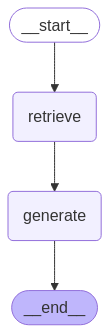

In [26]:
def retrieve(state: State):
    search_results = retriever.vectorstore.similarity_search(state["question"])
    retrieved_docs = retriever.invoke(state["question"])
    return {
        "search_results": search_results,
        "context": retrieved_docs
    }

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

In [27]:
print(agent_query)
response = graph.invoke({"question": agent_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'search_results': [
        Document(
            id='213194f4-602f-4fc1-9959-17971b2a71ba',
            metadata={'doc_id': '19b46fba-e616-4fd8-b299-e878d471fcd6'},
            page_content='The document "LLM Powered Autonomous Agents" by Lilian Weng delves into the development 
and function'+2385
        ),
        Document(
            id='ad88eae6-8726-441c-9c8f-06c7f8a6b666',
            metadata={'doc_id': '6b76c1f3-9c48-4e4f-aa1e-b5ffe67f2826'},
            page_content='The document "Thinking about High-Quality Human Data" by Lilian Weng discusses the 
importance of hig'+1681
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  
Estimated Reading Tim'+28918
        )
    ],
    'answer': 'Task decomposition for LLM (large language model) agents refers to the process of breaking down 
comp'+1576
}

Task decomposition for LLM (large language model) agents refers to the process of breaking down complex tasks into 
smaller, more manageable subgoals. This approach helps LLM agents handle intricate tasks more efficiently by       
tackling them step by step. Here are some key aspects of task decomposition in the context of LLM-powered          
autonomous agents:                                                                                                 

 1 Chain of Thought (CoT): This technique encourages models to “think step by step,” allowing them to decompose    
   difficult tasks into simpler components. By framing prompts that guide LLMs to articulate their reasoning       
   process, CoT enhances the model's performance on complex queries.                                               
 2 Tree of Thoughts (ToT): Building on CoT, ToT introduces multiple reasoning possibilities at each step. It       
   structures the problem into various thought steps and generates multiple thoughts per step, forming a tree-like 
   structure that can be explored through various search methods, such as breadth-first or depth-first search.     
 3 Human and Task-Specific Input: Task decomposition can be achieved by utilizing simple prompting with specific   
   instructions or directly soliciting human input to guide the model in identifying the necessary subgoals.       
 4 LLM+P: This approach employs an external classical planner that utilizes the Planning Domain Definition Language
   (PDDL) to outline the planning problem. LLMs translate the problem into PDDL, which is then processed by an     
   external planner, and the output is translated back into natural language.                                      

By effectively decomposing tasks, LLM agents can systematically address each subgoal, which leads to improved      
overall performance and quality in completing complex objectives.

In [29]:
print(human_data_query)
response = graph.invoke({"question": human_data_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What are main steps for collecting human data?


{
    'question': 'What are main steps for collecting human data?',
    'search_results': [
        Document(
            id='ad88eae6-8726-441c-9c8f-06c7f8a6b666',
            metadata={'doc_id': '6b76c1f3-9c48-4e4f-aa1e-b5ffe67f2826'},
            page_content='The document "Thinking about High-Quality Human Data" by Lilian Weng discusses the 
importance of hig'+1681
        ),
        Document(
            id='213194f4-602f-4fc1-9959-17971b2a71ba',
            metadata={'doc_id': '19b46fba-e616-4fd8-b299-e878d471fcd6'},
            page_content='The document "LLM Powered Autonomous Agents" by Lilian Weng delves into the development 
and function'+2385
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  
Estimated Reading Tim'+28918
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
        )
    ],
    'answer': 'The main steps for collecting human data, as outlined in the provided context, are:\n\n1. **Task 
Desig'+758
}

The main steps for collecting human data, as outlined in the provided context, are:                                

 1 Task Design: Design the task workflow to improve clarity and reduce complexity. This involves creating detailed 
   guidelines that are useful without being overly complicated.                                                    
 2 Select and Train a Pool of Raters: Choose annotators who have the appropriate skill sets and ensure consistency.
   This also includes conducting training sessions and providing regular feedback and calibration sessions after   
   onboarding.                                                                                                     
 3 Collect and Aggregate Data: This stage involves the actual collection of data from the raters and applying      
   machine learning techniques to clean, filter, and aggregate the data, aiming to identify the true labels.       

These steps are critical for ensuring the quality of human-annotated data, which is essential for training deep    
learning models.